In [282]:
NORMAL_DRIVING_PATH = './data2/normal/'
CORRECTIN_DRIVING_PATH = './data2/correcting/'
REVERSE_DRIVING_PATH = './data2/reverse/'
normal_liens = []
correction_lines = []
reverse_lines = []

In [283]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def get_lines(path):
    lines = []
    with open ('%sdriving_log.csv' % path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        return lines


normal_lines = get_lines(NORMAL_DRIVING_PATH)
correction_lines = get_lines(CORRECTIN_DRIVING_PATH)
reverse_lines = get_lines(REVERSE_DRIVING_PATH)

all_lines = normal_lines + correction_lines + reverse_lines

#all_lines = normal_lines + reverse_lines
print(normal_lines[0][0].split('/')[-1])
#print(correction_lines[0][0].split('/')[-1])
#print(reverse_lines[0][0].split('/')[-1])



center_2017_11_04_09_05_52_691.jpg


In [157]:
sample_lines = get_lines('./samples-training/data/')[1:]

In [284]:
# Let's look at the distribution of angles
def plot_histogram(labels, bins):
    history, bins = np.histogram(labels, bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, history, align='center', width=width)
    plt.show()

In [285]:
def get_soft_sharp_split(data, threshold=0.3):
    soft_turns = []
    sharp_turns = []
    for line in data:
        if abs(float(line[ANGLE])) >= threshold:
            sharp_turns.append(line)
        else:
            soft_turns.append(line)
    return soft_turns, sharp_turns

In [286]:
def analyze_dataset(lines):
    lines = np.asarray(lines)
    angles = lines[:,3].astype(np.float)
    min_angle = np.amin(angles)
    max_angle = np.amax(angles)
    bins = np.arange(min_angle, max_angle, step=0.005)

    plot_histogram(angles, bins)
    soft, sharp = get_soft_sharp_split(lines)
    print("Total examples: %d" % len(lines))
    print("Number of soft turns: %d" % len(soft))
    print("Number of sharp turns: %d" % len(sharp))

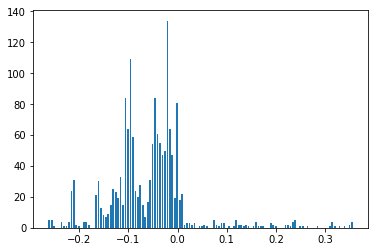

Total examples: 1606
Number of soft turns: 1580
Number of sharp turns: 26


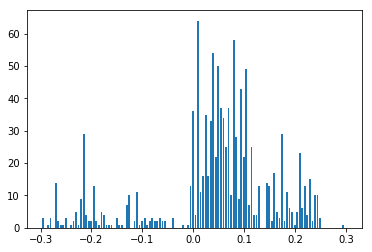

Total examples: 1136
Number of soft turns: 1133
Number of sharp turns: 3


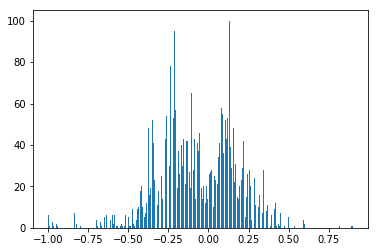

Total examples: 4681
Number of soft turns: 3829
Number of sharp turns: 852


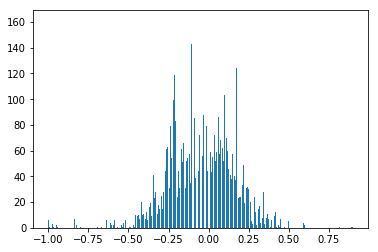

Total examples: 7423
Number of soft turns: 6542
Number of sharp turns: 881


In [287]:
analyze_dataset(normal_lines)
analyze_dataset(reverse_lines)
analyze_dataset(correction_lines)
analyze_dataset(all_lines)

In [252]:
def load_image(img_full_path):
    # Name of the img, e.g. center_2017_10_24_17_22_37_747.jpg
    name = img_full_path.split('/')[-1]

    # Mode, i.e. normal, correcting, reverse
    dataset = img_full_path.split('/')[-3]

    path = './data2/%s/IMG/%s' % (dataset, name)
    #path = './samples-training/data/IMG/%s' % name
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

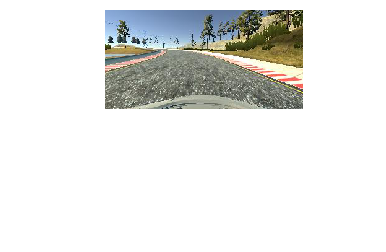

In [253]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(all_lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

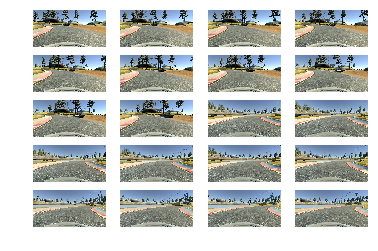

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4)

ax = ax.ravel()

right_count = 0
left_count = 0
left = []
right = []

for line in all_lines:
    angle = float(line[3])
    if angle > 0.2 and right_count < 10:
        right.append(load_image(line[0]))
        right_count += 1
    elif angle < -0.2 and left_count < 10:
        left.append(load_image(line[0]))
        left_count += 1

    

for i in range(0, 20):
    ax[i].imshow(left[i] if i < 10 else right[i-10])

for a in ax:
    a.axis('off')

In [203]:
import numpy as np
from skimage import transform

def random_translate(img, steering_angle, is_debug=False):
    random_x = np.random.randint(-50, 50)
    random_y = np.random.randint(-25, 25)
    steering_angle = steering_angle + random_x * 0.004
    tform = transform.SimilarityTransform(translation=(random_x, random_y))
    translated = transform.warp(img, tform)
    if is_debug:
        print('Random X: %s, Random Y: %s, Steering Angle Adjustment: %s' %(random_x, random_y, steering_angle))
    return translated, steering_angle

In [204]:
def random_brightness(img):
    img = np.array(img, dtype=np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness = .25 + np.random.uniform()
    hsv[:,:,2] = hsv[:,:,2] * brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

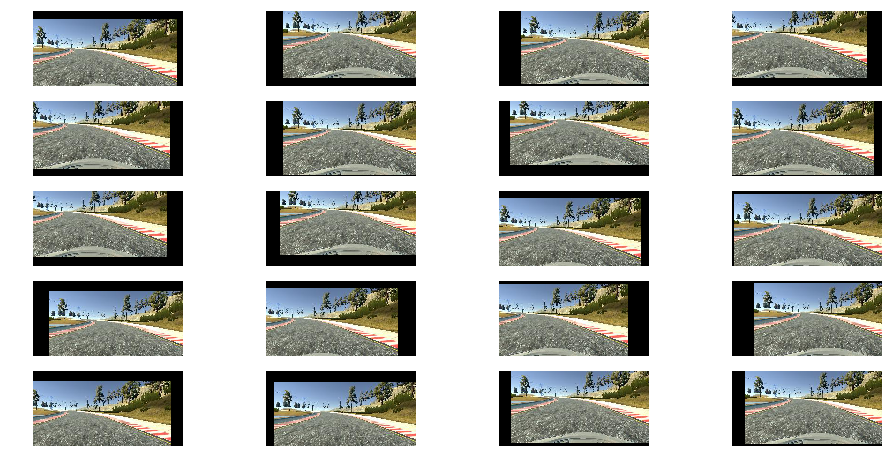

In [205]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 8))

ax = ax.ravel()

for i in range(0, 20):
    translated, _ = random_translate(sample_img, steering_angle)
    ax[i].imshow(translated)

for a in ax:
    a.axis('off')

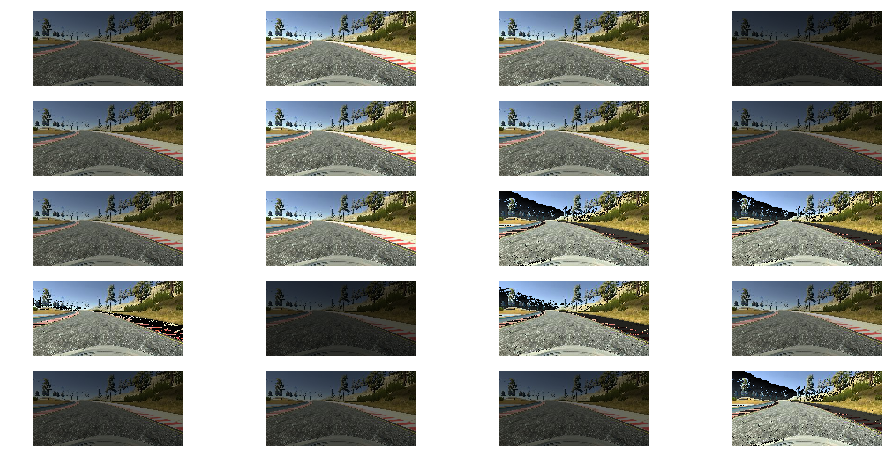

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 8))

ax = ax.ravel()

for i in range(0, 20):
    bright = random_brightness(sample_img)
    ax[i].imshow(bright)

for a in ax:
    a.axis('off')

In [210]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

def get_training_image(line, camera=None):
    camera = np.random.randint(CENTER, RIGHT + 1) if camera is None else camera
    camera_img = load_image(line[camera])
    angle = float(line[ANGLE])

    steering_correction = 0.0

    if camera is LEFT:
        steering_correction = LEFT_ANGLE_CORRECTION
    elif camera is RIGHT:
        steering_correction = RIGHT_ANGLE_CORRECTION

    return camera_img, angle + steering_correction
    

In [211]:
def drop_random_low_angles(data, keep_probability=0.6, threshold=0.2):
    new_data = []
    for line in data:
        angle = abs(float(line[ANGLE]))
        if angle < threshold:
            if np.random.uniform() < keep_probability:
                new_data.append(line)
        else:
            new_data.append(line)
    return new_data

In [229]:
# Split the data between soft turn and sharp turns
THRESHOLD = 0.25

soft_turns, sharp_turns = get_soft_sharp_split(all_lines, THRESHOLD)

print("Number of sharp turns: %d" % len(sharp_turns))
print("Number of soft turns: %d" % len(soft_turns))

with_low_angles = list(filter(lambda line: abs(float(line[ANGLE])) < 0.2, all_lines))
with_dropped_angles = drop_random_low_angles(all_lines)
total_lines = len(all_lines)

print("Number with low angles: %d (%f percent)" % (len(with_low_angles), len(with_low_angles) / total_lines * 100))
print("Number with low angles dropped: %d (%f percent)" % (len(with_dropped_angles), len(with_dropped_angles) / total_lines * 100))
print("Length of all lines: %d" % total_lines)
print("Length of Dropped: %d" % len(with_dropped_angles))

sharp = list(filter(lambda x: abs(float(x[ANGLE])) > 0.2, with_dropped_angles))

Number of sharp turns: 655
Number of soft turns: 3671
Number with low angles: 3123 (72.191401 percent)
Number with low angles dropped: 3091 (71.451687 percent)
Length of all lines: 4326
Length of Dropped: 3091


In [230]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

In [231]:
def make_validation_generator(data, batch_size=256):
    while True:
        num_samples = len(data)
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                img = load_image(batch_sample[CENTER])
                angle = float(batch_sample[ANGLE])
                images.append(img)
                angles.append(angle)
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield x_images, y_labels
                

In [232]:
import sklearn.utils

train_num_samples = 0

def make_train_generator(data, batch_size=256):
    data = sklearn.utils.shuffle(data)
    num_samples = len(data)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:

                img, angle = get_training_image(batch_sample)
                
                images.append(img)
                angles.append(angle)
                
                # Apply some random brightness and translation.
                augmented_img = random_brightness(img)
                augmented_img, augmented_angle = random_translate(augmented_img, angle)
                #augmented_img = random_brightness(augmented_img)

                # Maybe flip the image
                if np.random.randint(2):
                    augmented_img = np.fliplr(augmented_img)
                    augmented_angle *= -1

                images.append(augmented_img)
                angles.append(augmented_angle * -1)

                left_camera, left_angle = get_training_image(batch_sample, camera=LEFT)
                right_camera, right_angle = get_training_image(batch_sample, camera=RIGHT)
                images.append(left_camera)
                images.append(right_camera)
                angles.append(left_angle)
                angles.append(right_angle)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [294]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(all_lines, test_size=0.2)
print("Number of training examples before dropping low angles: %d" % len(train_samples))
train_samples = drop_random_low_angles(train_samples, keep_probability=0.5, threshold=0.3)
print("Number of training examples after dropping low angles: %d" % len(train_samples))

soft, sharp = get_soft_sharp_split(train_samples, threshold=0.35)
print("Number of soft angles: %d" % len(soft))
print("Number of sharp angles: %d" % len(sharp))

soft_turns, sharp_turns = get_soft_sharp_split(train_samples)
to_add = len(soft_turns) - len(sharp_turns)
print("Need to add %d additional" % to_add)

# Add more sharp turns
for i in range(to_add):
    # Modulo so we can start from the beginning again
    sharp_turns.append(sharp_turns[i % len(sharp_turns)])

train_samples = sklearn.utils.shuffle(sharp_turns + soft_turns)
train_num_samples = len(train_samples)


train_generator = make_train_generator(train_samples, batch_size=256)
validation_generator = make_validation_generator(validation_samples, batch_size=256)
print("Number of train examples: %d" % train_num_samples)

Number of training examples before dropping low angles: 5938
Number of training examples after dropping low angles: 3290
Number of soft angles: 2852
Number of sharp angles: 438
Need to add 1864 additional
Number of train examples: 5154


In [289]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [295]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout
from keras.optimizers import Adam

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# Resize the image to match the nvidia sizes.
model.add(Lambda(resize))

# Normalize the image.
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv4', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv5', activation='elu'))

model.add(Flatten())
#model.add(Dense(1, activation='elu'))

model.summary()

model.add(Dense(1164, name='desn1164', activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, name='dense100'))
model.add(Dropout(0.5))
model.add(Dense(50, name='dense50'))
model.add(Dropout(0.5))
model.add(Dense(10, name='dense10'))
model.add(Dense(1, name='dense1'))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples) * 4,    # * 6 for center, left, and right image
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples) * 1,  # * 6 for center, left, and right image
    nb_epoch=5)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_27 (Cropping2D)       (None, 90, 320, 3)    0           cropping2d_input_27[0][0]        
____________________________________________________________________________________________________
lambda_51 (Lambda)               (None, 66, 200, 3)    0           cropping2d_27[0][0]              
____________________________________________________________________________________________________
lambda_52 (Lambda)               (None, 66, 200, 3)    0           lambda_51[0][0]                  
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_52[0][0]                  
___________________________________________________________________________________________

In [186]:
model.save('model.h5')